In [1]:
import scipy.linalg
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.utils
import sklearn.model_selection
import sklearn.metrics
import pandas as pd

In [2]:
sys.path.insert(0, "..")

In [3]:
from hmm import GaussianVariationalMHMM, HMMCluster, GaussianMHMM, plots
from hmm import GaussianHMM, GaussianVariationalHMM
from hmm.datasets import synthetic, for_tests

In [4]:
random_state = sklearn.utils.check_random_state(None)

## Dataset from Smyth
Use a dataset from Padraich Smyth ~1997 on Clustering with HMMs.  Clusters sequences generated from 2-state HMMS with identical Gaussian emissions but differing transition probabilities.  He trains on 20 sequences of length 200 from each model.

The gaussians have variance of 1 and are centered at 0 and 3.

The transition matrices are:

```
    [[ .4, .6], 
    [.6, .4]]
```

and 

``` 
    [[.6, .4], 
    [.4, .6]]```

In [5]:
model1, model2 = synthetic.get_smyth_clustering_models(random_state=random_state)

In [6]:
train_size = .5
train_number = 20
n_samples = int(train_number / train_size )
model1_samples = model1.sample(n_samples, 200)[0]
model2_samples = model2.sample(n_samples, 200)[0]

In [7]:
all_samples_smyth = np.concatenate([model1_samples, model2_samples])

labels_smyth = np.asarray([0] * n_samples + [1] * n_samples)
all_samples_smyth.shape

(80, 200)

In [8]:
train_data_smyth, test_data_smyth, train_labels_smyth, test_labels_smyth = sklearn.model_selection.train_test_split(
    all_samples_smyth, labels_smyth, test_size=.5, stratify=labels_smyth)

In [9]:
actual = GaussianMHMM.GaussianMHMM(n_mixture_components=2, n_components=2, n_inits=1)
actual.fit(train_data_smyth)

GaussianMHMM(allowed_to_use_log=True, implementation='scaling',
       init_A='random', init_emissions='kmeans',
       init_mixture_weights='uniform', init_pi='random', n_components=2,
       n_inits=1, n_iterations=100, n_jobs=-1, n_mixture_components=2,
       random_state=None, tol=1e-06, variance_regularization=1e-06,
       verbose=0)

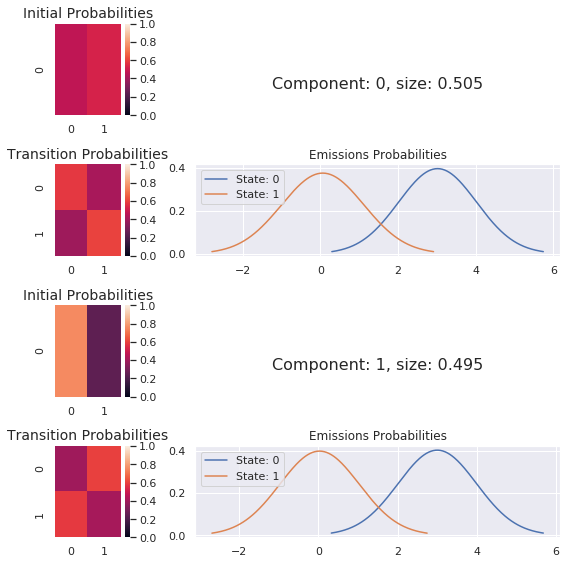

In [10]:
_ = plots.gaussian_mixture_hinton(
    actual.mixture_weights_,
    actual.pi_,
    actual.A_,
    actual.means_,
    actual.variances_,
    vmin=0,
    vmax=1)

In [11]:
print("num params:", actual.num_free_params())
print("BIC:", actual.bic(train_data_smyth))
print("AIC:", actual.aic(train_data_smyth))
print("CAIC:", actual.caic(train_data_smyth))
print("LL-Train:", actual.score(train_data_smyth))
print("LL-Test:", actual.score(test_data_smyth))


num params: 15
BIC: 31190.01297520775
AIC: 31085.20502289782
CAIC: 31205.01297520775
LL-Train: -388.1900627862227
LL-Test: -386.2782595967115


# Experiments

In [12]:
n_inits = 10
n_jobs = 4
tol=1e-8

n_iterations = 2000

In [13]:
def compute_metrics(models, data):
    mixture_results = []
    for (n_mixture_components, n_components), model in models.items():
        r = {}
        r["K"] = n_mixture_components
        r["N"] = n_components
        r["LB"] = model.lower_bound_[-1]
        r["ALB"] = model.adjusted_lower_bound_[-1]
        r["BIC"] = model.bic(data)
        r["AIC"] = model.aic(data)
        r["CAIC"] = model.caic(data)
        r["LL"] = model.score(data)
        r["iter"] = len(model.lower_bound_)
        r["params"] = model.num_free_params()
        mixture_results.append(r)

    columns = ["LB", "ALB", "AIC", "BIC", "CAIC", "LL", "iter", "params"]

    return pd.DataFrame(mixture_results).set_index(["K", "N"])[columns]



In [14]:
variational_models = {}
for n_mixture_components in range(1, 4):
    print(n_mixture_components)
    if n_mixture_components == 1:
        for n_components in range(2,7):
            print(n_mixture_components, n_components)
            m = GaussianVariationalHMM.GaussianVariationalHMM(
                n_components=n_components,
                n_inits=n_inits,
                n_iterations=n_iterations,
                tol=tol)
            m.fit(train_data_smyth)
            variational_models[(n_mixture_components, n_components)] = m
    else:
        for n_components in range(2,4):
            print(n_mixture_components, n_components)
            m = GaussianVariationalMHMM.GaussianVariationalMHMM(
                n_mixture_components=n_mixture_components,
                n_components=n_components,
                n_inits=n_inits,
                n_iterations=n_iterations,
                tol=tol
            )
            m.fit(train_data_smyth)
            variational_models[(n_mixture_components, n_components)] = m

1
1 2
1 3
1 4
1 5
1 6
2
2 2
2 3
3
3 2
3 3


In [15]:
mixture_results = compute_metrics(variational_models, train_data_smyth)

In [16]:
mixture_results

LB          ALB           AIC           BIC          CAIC  \
K N                                                                       
1 2 -8260.601998 -8259.908851  31211.369090  31288.228255  31299.228255   
  3 -8272.967124 -8271.175365  31226.531943  31366.275879  31386.275879   
  4 -8273.974708 -8270.796655  31227.292036  31360.048775  31379.048775   
  5 -8307.330108 -8302.542616  31219.508696  31443.098995  31475.098995   
  6 -8297.273403 -8290.694152  31248.235887  31464.838988  31495.838988   
2 2 -8237.785747 -8236.399453  31046.038223  31206.743750  31229.743750   
  3 -8253.403059 -8250.918153  31046.029985  31206.735512  31229.735512   
3 2 -8239.943710 -8237.458804  31046.038212  31206.743739  31229.743739   
  3 -8255.561021 -8251.977502  31046.029973  31206.735500  31229.735500   

             LL  iter  params  
K N                            
1 2 -389.867114   222      11  
  3 -389.831649  2000      20  
  4 -389.866150  1598      19  
  5 -389.443859  2000      32  
  6 -389.827949  2000      31  
2 2 -387.500478   219      23  
  3 -387.500375   507      23  
3 2 -387.500478   209      23  
  3 -387.500375  1992      23

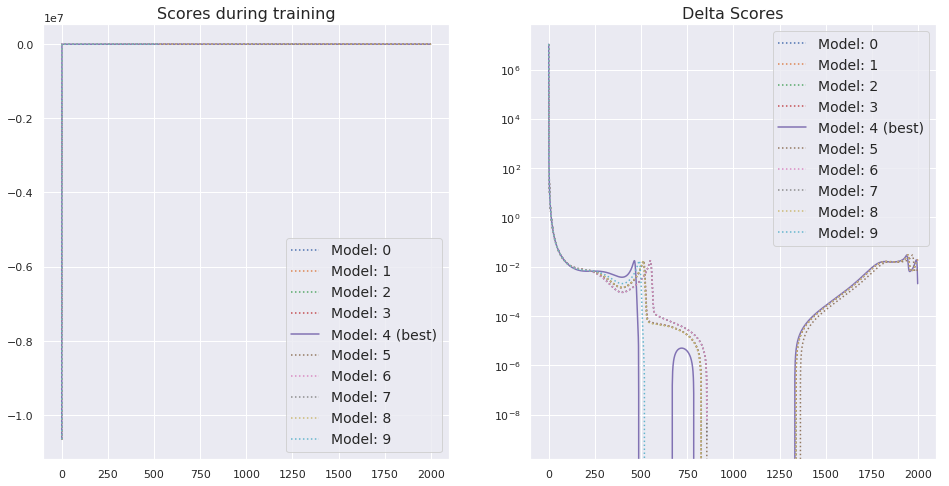

In [17]:
_ = plots.multiple_learning_plot(variational_models[(1,3)].explored_lower_bounds_)

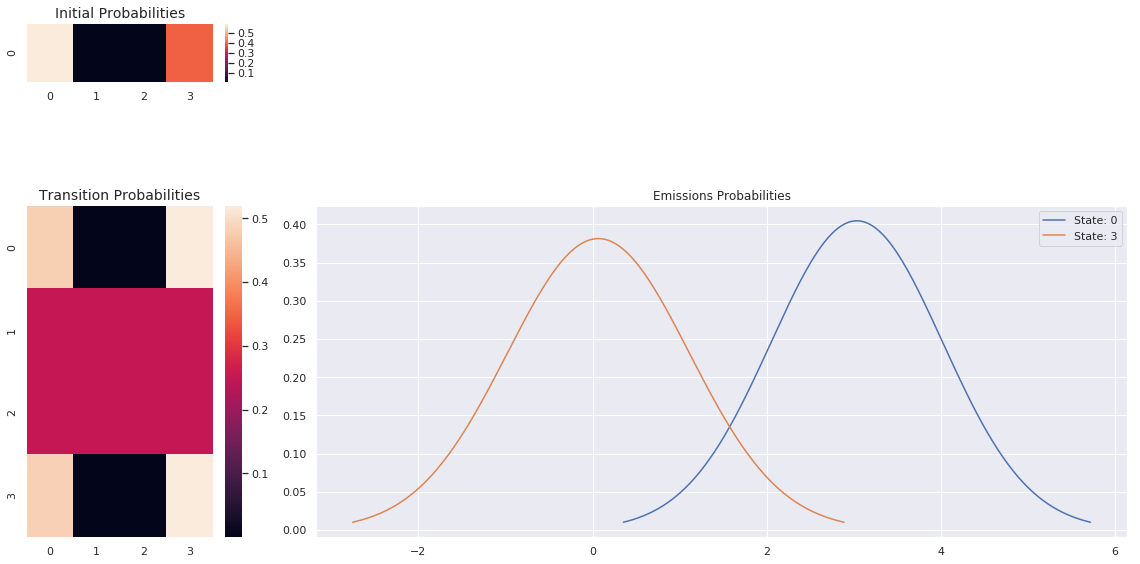

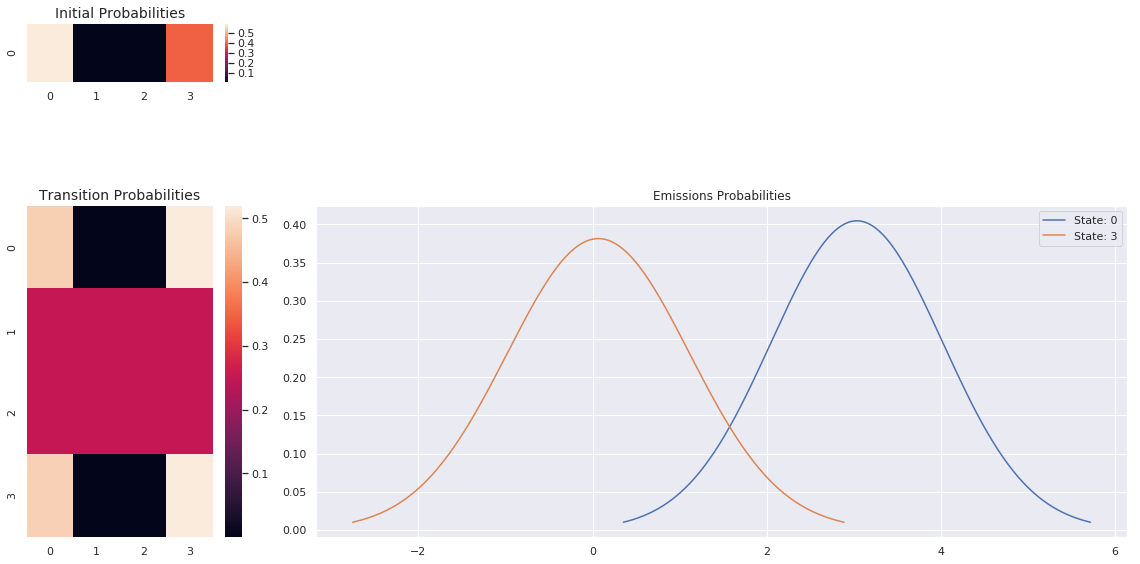

In [18]:
plots.gaussian_hinton_diagram(
    variational_models[(1,4)].pi_normalized_,
variational_models[(1,4)].A_normalized_,
variational_models[(1,4)].means_posterior_,
    variational_models[(1,4)].variances_posterior_,
)

In [19]:
def do_hinton(model):
    print(model.mixture_weights_normalized_)
    plots.gaussian_mixture_hinton(
        model.mixture_weights_normalized_,
        model.pi_normalized_,
        model.A_normalized_,
        model.means_posterior_,
        model.variances_posterior_,
        vmin=0,
        vmax=1)
        

[0.49238358 0.00813008 0.49948634]


No handles with labels found to put in legend.


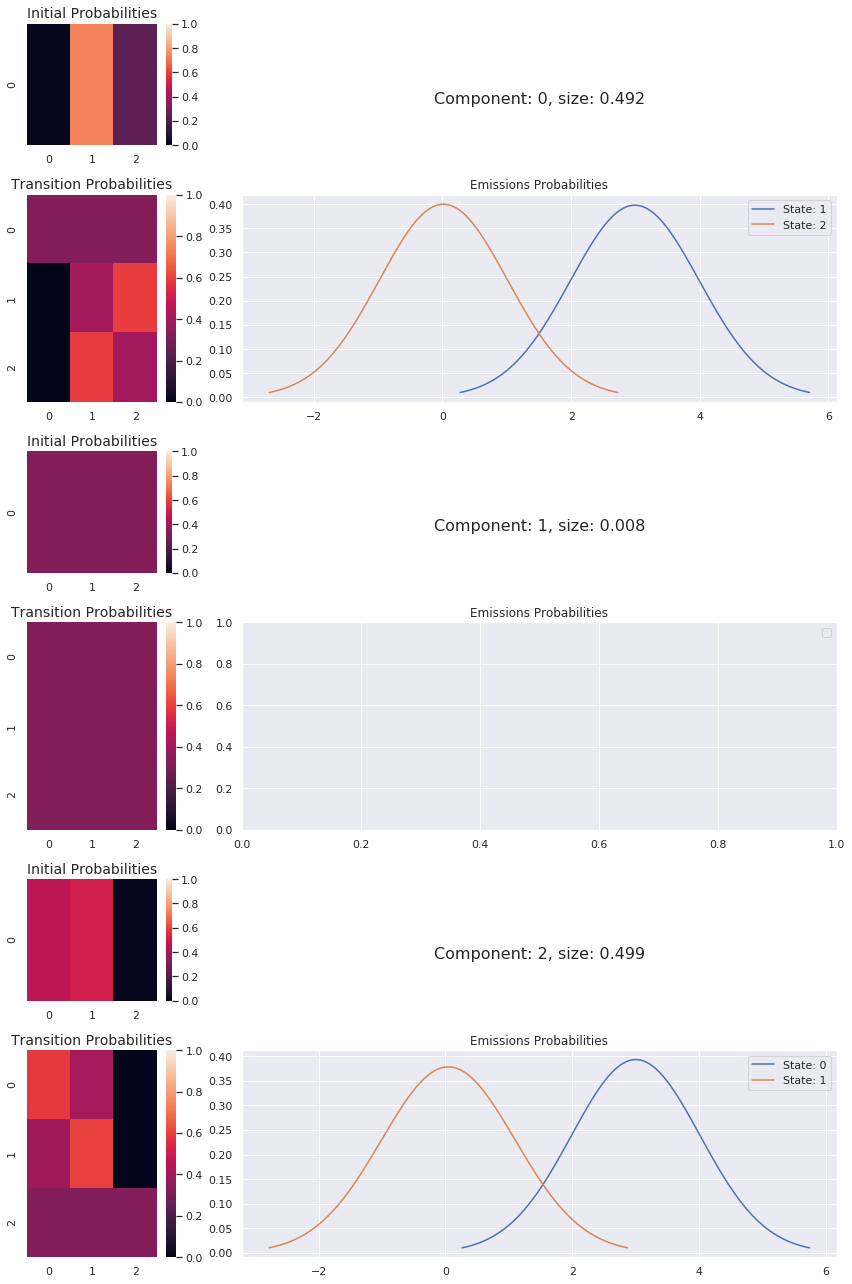

In [20]:
do_hinton(variational_models[(3, 3)])

[0.49238358 0.00813008 0.49948634]


No handles with labels found to put in legend.


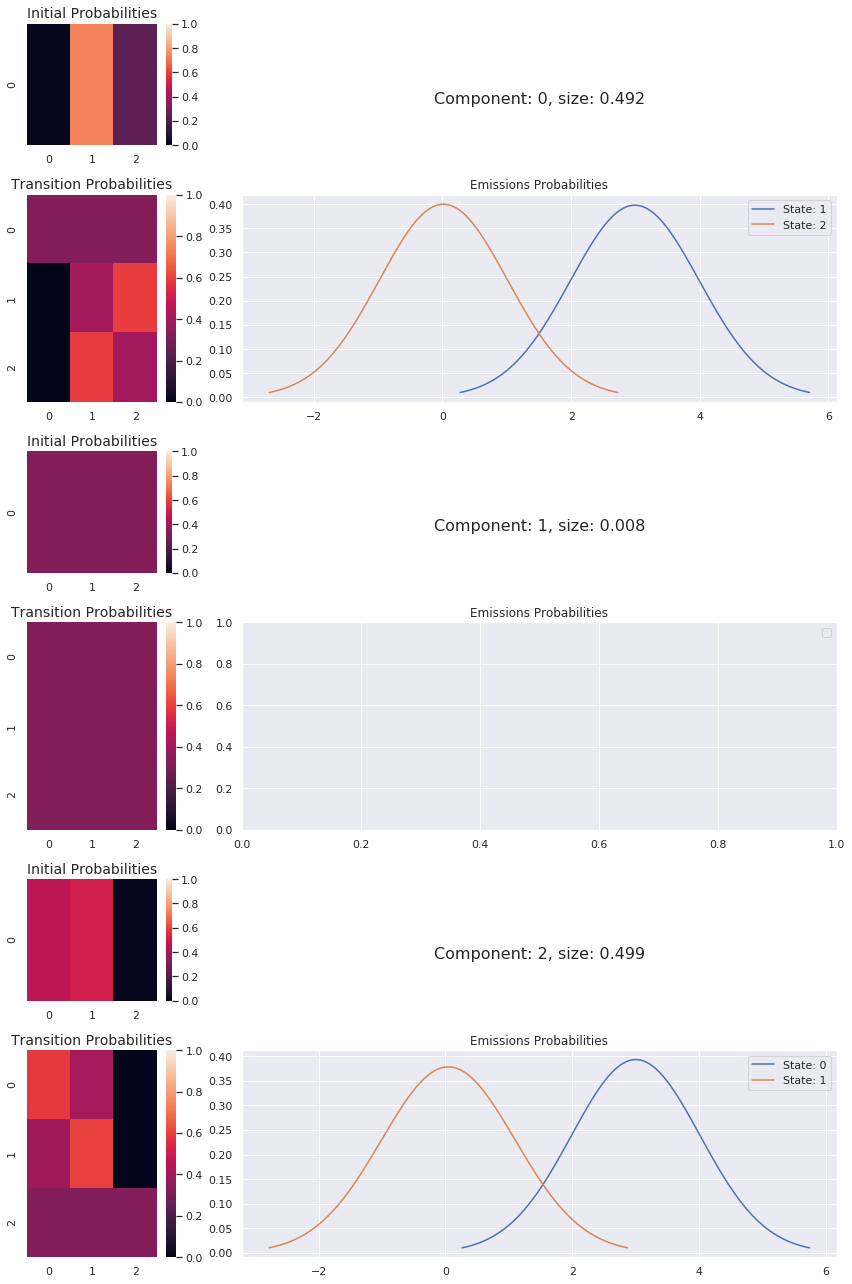

In [21]:
do_hinton(variational_models[(3,3)])

In [22]:
variational_mixture = GaussianVariationalMHMM.GaussianVariationalMHMM(
    n_mixture_components=2,
    n_components=2,
    n_iterations=n_iterations,
    n_inits=n_inits,
    n_jobs=-1
)


In [23]:
variational_mixture.fit(train_data_smyth)

GaussianVariationalMHMM(A_prior=None, allowed_to_use_log=True,
            implementation='scaling', init_mixture_weights=None,
            means_prior='uninformed', mixture_weights_prior=None,
            n_components=2, n_inits=10, n_iterations=2000, n_jobs=-1,
            n_mixture_components=2, pi_prior=None, random_state=None,
            tol=1e-06, variances_prior='uninformed', verbose=0)

In [24]:
variational_mixture.lower_bound_[-1]

-8237.785650745609

[0.49657044 0.50342956]


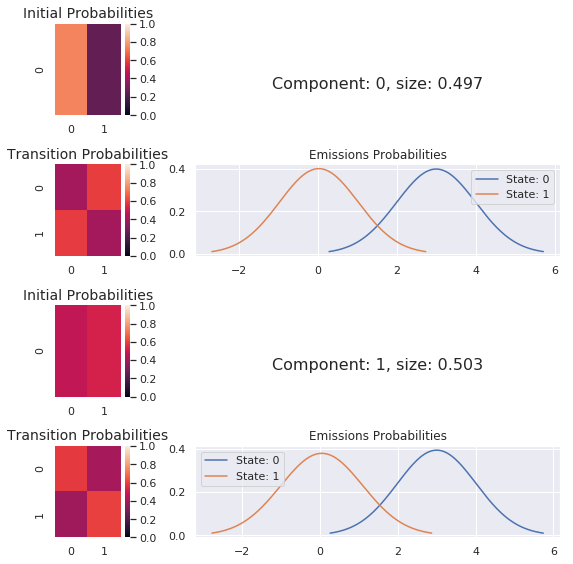

In [25]:
do_hinton(variational_mixture)

## Block

In [46]:
class EMBlock(GaussianHMM.GaussianHMM):
    def _init_A(self, X):
        rs = sklearn.utils.check_random_state(self.random_state)
        blocks = []
        for i in range(3):
            blocks.append(
                sklearn.preprocessing.normalize(
                    rs.rand(3,3),
                    norm="l1",
                    axis=1)
            )
    
        self.A_ = scipy.linalg.block_diag(*blocks)

    pass


In [48]:
em_block = EMBlock(n_components=9, n_iterations=1000)

In [49]:
em_block.fit(train_data_smyth)

../hmm/HMMBase.py:142: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)


EMBlock(allowed_to_use_log=True, implementation='scaling', init_A='random',
    init_emissions='kmeans', init_pi='random', n_components=9, n_inits=1,
    n_iterations=1000, n_jobs=-1, random_state=None, tol=1e-06,
    variance_regularization=1e-06, verbose=0)

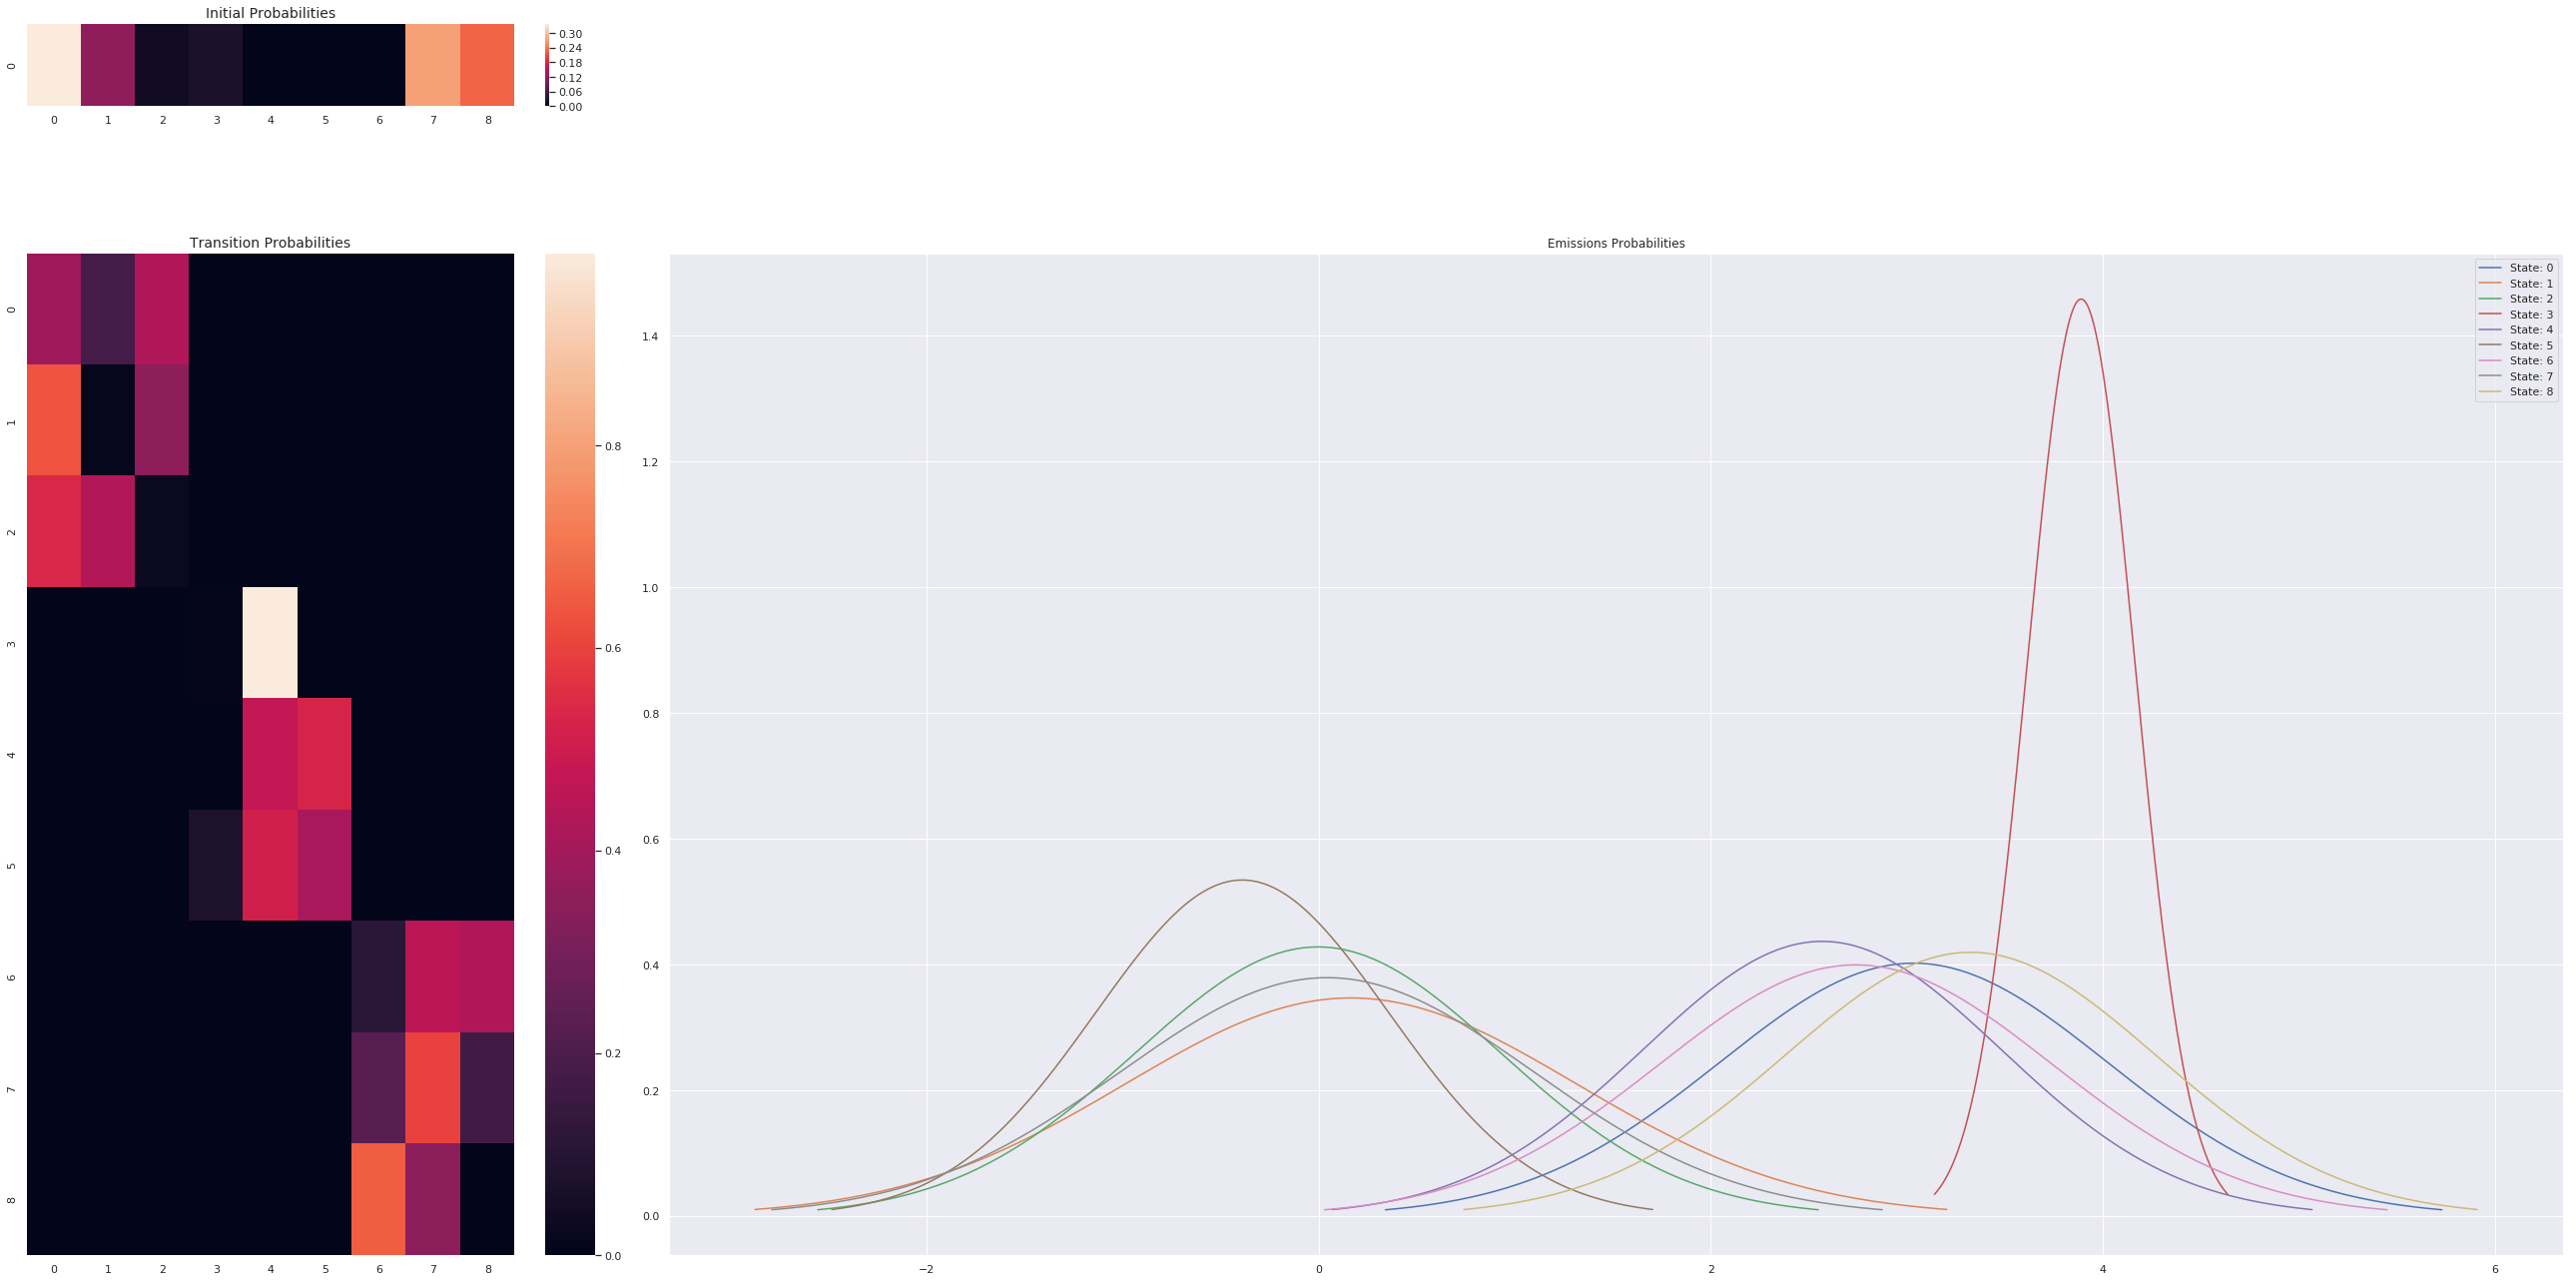

In [51]:
_ = plots.gaussian_hinton_diagram(
    em_block.pi_,
    em_block.A_,
    em_block.means_,
    em_block.variances_)

In [53]:
class VariationalBlock(GaussianVariationalHMM.GaussianVariationalHMM):
    def _init_A(self, X):
        rs = sklearn.utils.check_random_state(self.random_state)
        blocks = []
        for i in range(3):
            blocks.append(
                sklearn.preprocessing.normalize(
                    rs.rand(3,3),
                    norm="l1",
                    axis=1)
            )
    
        self.A_prior_ = scipy.linalg.block_diag(*blocks)
        self.A_prior_[self.A_prior_==0] = 1/100000
        self.A_prior_ = sklearn.preprocessing.normalize(self.A_prior_, norm="l1", axis=1)
        #print(self.A_prior_)
        self.A_counts_ = self.A_prior_ * X.shape[0] * X.shape[1] / 4
    pass


In [67]:
vb_block = VariationalBlock(n_components=9, n_iterations=n_iterations, n_inits=10, n_jobs=1, tol=1e-10)
#em_block = EMBlock(n_components=9, n_iterations=10000, n_inits=1, n_jobs=1, tol=1e-10)

In [68]:
#em_block.fit(train_data_smyth)

In [69]:
vb_block.fit(train_data_smyth)

../hmm/VariationalHMMBase.py:117: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.verbose_lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:117: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.verbose_lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:117: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.verbose_lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:117: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.verbose_lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:117: UserWa

VariationalBlock(A_prior=None, implementation='scaling',
         means_prior='uninformed', n_components=9, n_inits=10,
         n_iterations=2000, n_jobs=1, pi_prior=None, random_state=None,
         tol=1e-10, variances_prior='uninformed', verbose=0)

In [79]:
vb_block.num_free_params()

39

In [80]:
variational_models[(3,3)].num_free_params()

23

In [70]:
vb_block.A_prior_

array([[2.57054441e-01, 3.96904521e-01, 3.45981042e-01, 9.99940004e-06,
        9.99940004e-06, 9.99940004e-06, 9.99940004e-06, 9.99940004e-06,
        9.99940004e-06],
       [4.06627646e-01, 4.19691796e-01, 1.73620562e-01, 9.99940004e-06,
        9.99940004e-06, 9.99940004e-06, 9.99940004e-06, 9.99940004e-06,
        9.99940004e-06],
       [4.37519515e-01, 2.93331016e-01, 2.69089473e-01, 9.99940004e-06,
        9.99940004e-06, 9.99940004e-06, 9.99940004e-06, 9.99940004e-06,
        9.99940004e-06],
       [9.99940004e-06, 9.99940004e-06, 9.99940004e-06, 1.90257220e-01,
        2.58093704e-01, 5.51589080e-01, 9.99940004e-06, 9.99940004e-06,
        9.99940004e-06],
       [9.99940004e-06, 9.99940004e-06, 9.99940004e-06, 4.79475294e-01,
        2.84918108e-01, 2.35546602e-01, 9.99940004e-06, 9.99940004e-06,
        9.99940004e-06],
       [9.99940004e-06, 9.99940004e-06, 9.99940004e-06, 5.38970330e-01,
        2.42692986e-01, 2.18276688e-01, 9.99940004e-06, 9.99940004e-06,
        9.9

In [71]:
vb_block.A_prior_.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

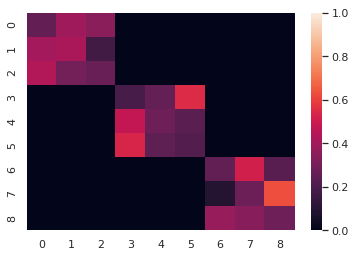

In [72]:
sns.heatmap(vb_block.A_prior_, vmin=0, vmax=1)

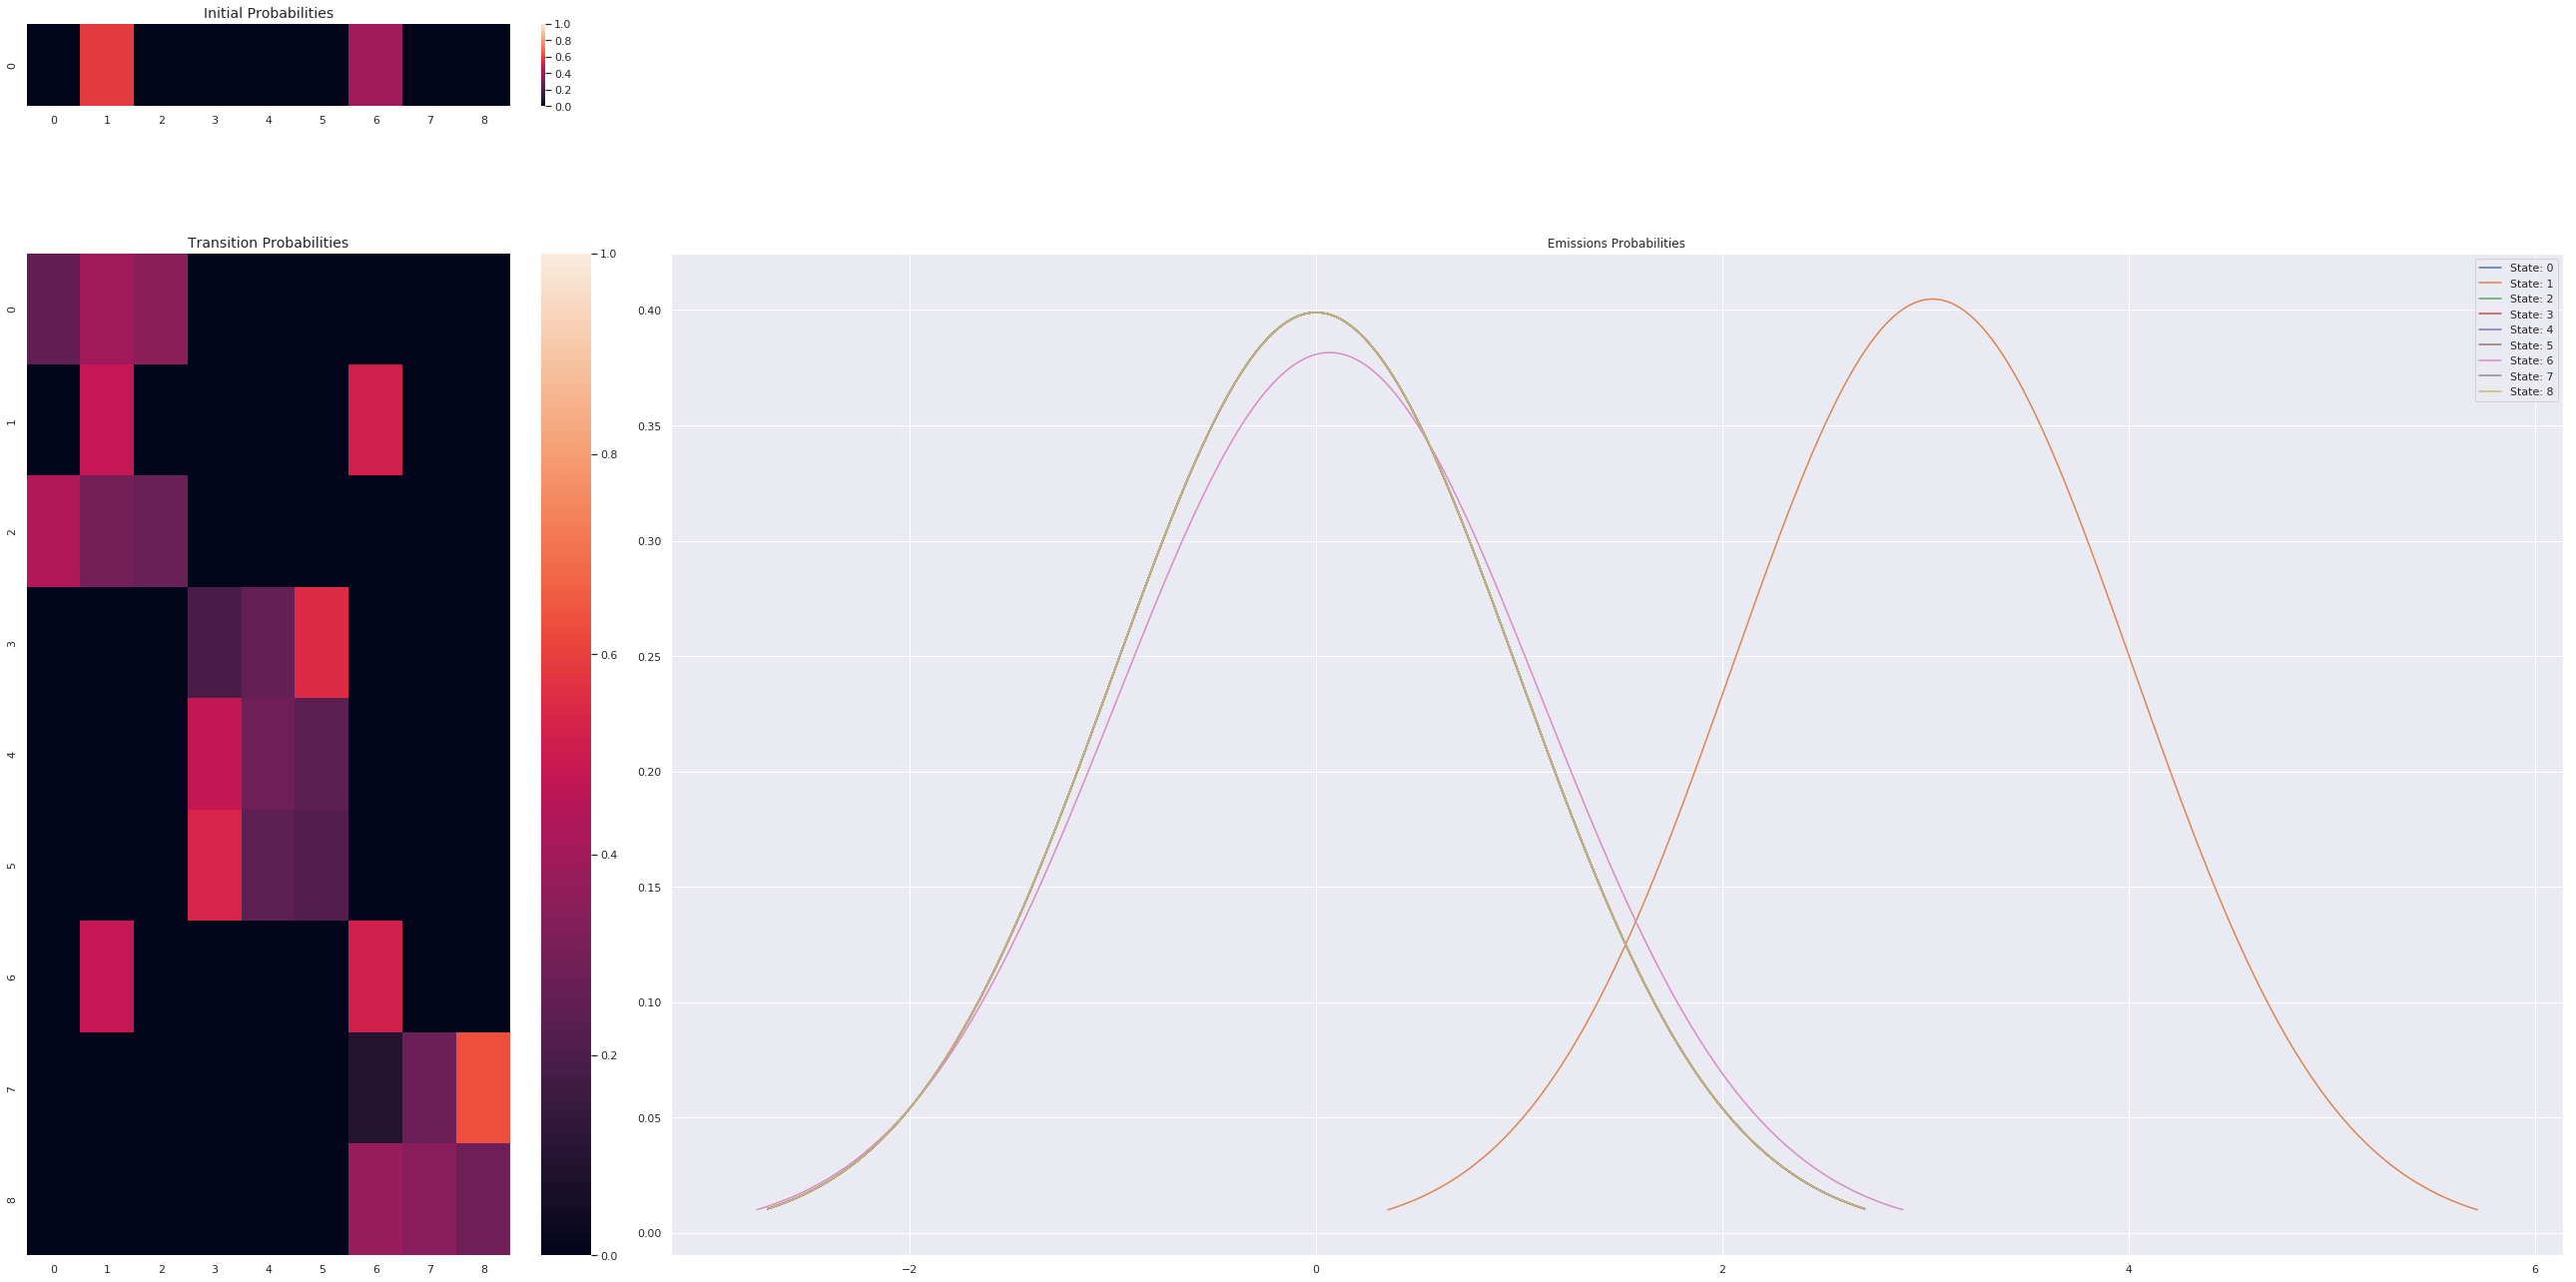

In [73]:
_ = plots.gaussian_hinton_diagram(
    vb_block.pi_normalized_,
    vb_block.A_normalized_,
    vb_block.means_posterior_,
    vb_block.variances_posterior_,
    vmin=0,
    vmax=1)

In [74]:
vb_block.verbose_lower_bound_[-1:]

[{'iteration': 1414,
  'total': -8298.931989046378,
  'pi': -6.244238084835068,
  'A': -39.29232442431112,
  'B': -4.608902394147604,
  'log_prob': -8248.786524143085}]

[0.49249987 0.49937005 0.00813008]


No handles with labels found to put in legend.


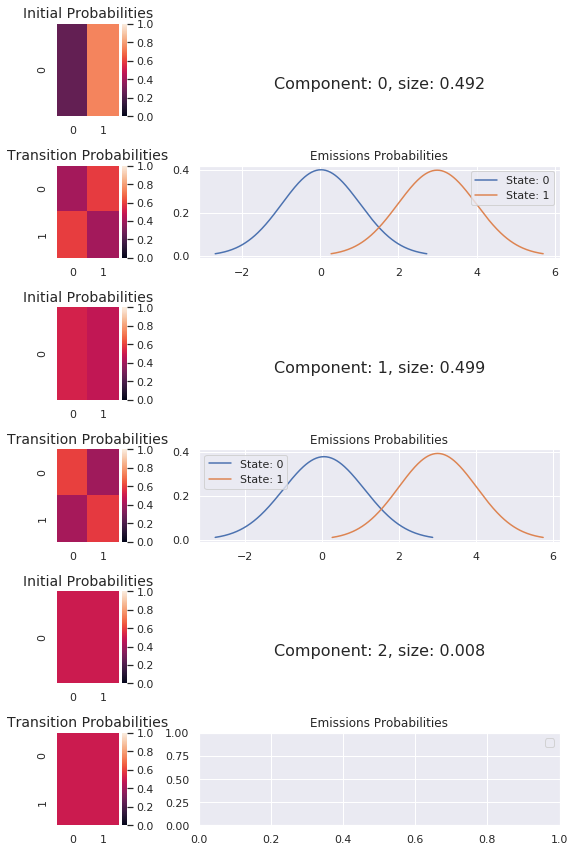

In [75]:
do_hinton(variational_models[(3,2)])

In [76]:
vb_block.verbose_lower_bound_[-1]

{'iteration': 1414,
 'total': -8298.931989046378,
 'pi': -6.244238084835068,
 'A': -39.29232442431112,
 'B': -4.608902394147604,
 'log_prob': -8248.786524143085}

In [77]:
variational_models[(2,2)].verbose_lower_bound_[-1]

{'iteration': 218,
 'total': -8237.785746978236,
 'component_states': -26.92872369785943,
 'component_weights': -1.5827288906552397,
 'pi': -2.5032981495635447,
 'A': -14.095685438498776,
 'B': -8.981434582671957,
 'log_prob': -8183.693876218987}

In [78]:
print("num", variational_models[(2,2)].num_free_params())
print("aic", variational_models[(2,2)].aic(train_data_smyth))
print("bic", variational_models[(2,2)].bic(train_data_smyth))
print("caic", variational_models[(2,2)].caic(train_data_smyth))

num 23
aic 31046.03822270677
bic 31206.743749581998
caic 31229.743749581998


In [66]:
print("num", vb_block.num_free_params())
print("aic", vb_block.aic(train_data_smyth))
print("bic", vb_block.bic(train_data_smyth))
print("caic", vb_block.caic(train_data_smyth))

num 51
aic 31248.623342901825
bic 31604.970380755585
caic 31655.970380755585


In [40]:
variational_models[(2,2)].score(train_data_smyth)

-387.50047778383464

In [41]:
vb_block.score(train_data_smyth)

-388.193034591859